In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
import random
import csv
import math
import statistics
import os
import os.path
from os import path
import time

random.seed(0)
np.random.seed(0)

In [2]:
# set home dir
os.chdir('..//..//')
os.getcwd();

In [3]:
# Out_dir is where you want all of the program output to be. The code will make subfolders for you nicely!
out_dir = 'other'
# Data_dir is where all of the stock data is
data_dir = "Data//Stocks_Sector_CC"

days_total = 60
window_size = 10
num_iter_test = 50

num_tasks = 45
epochs = 1000
# Should be 1 for meta-learning
num_iter_meta = 1

sample_size = 10

days_train = int(days_total * 0.7)

In [4]:
def writeCSV(directory, out_type, data):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Create subfolders and assign variables based on output type
    if(out_type in ["meta_data","train_data","profit_data","results_data"]):
        if(out_type == "meta_data"):
            folder = out_dir + "/meta"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Epoch","Reward"]
       
        if(out_type == "results_data"):
            folder = out_dir + "/final_results"
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Sample","Total Profit"]

        if(out_type == "train_data"):
            folder = (out_dir 
                      + "/trading_stats/" 
                      + "trading" 
                      + ident_fill 
                      + '/train')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Iteration","Reward"]

        if(out_type == "profit_data"):
            folder = (out_dir + "/trading_stats/" + "trading" + ident_fill + '/trade_balance')
            if(not path.exists(out_dir + "/trading_stats")):    
                os.mkdir(out_dir + "/trading_stats")
            if(not path.exists(out_dir + "/trading_stats/trading" + ident_fill)):    
                os.mkdir(out_dir + "/trading_stats/trading" + ident_fill)
            if(not path.exists(folder)):    
                os.mkdir(folder)
            cols = ["Day","Profit"]
            
        fileName = (folder + '/' + out_type + ident_fill + " - {}.csv")
        
        # Save file with incremented ending
        i = 1
        while(path.exists(fileName.format(i))):
            i += 1
        saveFile = fileName.format(i)
        
        # Write to csv file with cols as headers, integer indicies, and data
        with open(saveFile, mode='x', newline='') as test_file:
            test_writer = csv.writer(test_file, delimiter=',', quotechar='\"', quoting=csv.QUOTE_MINIMAL)
            test_writer.writerow(cols)
            for i,j in zip(data,range(0, len(data))):
                test_writer.writerow([str(j), str(i)])
        test_file.close()

    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta_data\'\n' 
                        + '\'train_data\'\n' 
                        + '\'profit_data\'\n'
                        + '\'results_data\'\n')

    
def saveFig(directory, out_type):
    identifier = '_e_{}_t_{}_im_{}_it_{}_d_{}_w_{}'
    ident_fill = identifier.format(epochs,num_tasks,num_iter_meta,num_iter_test,days_total,window_size)
    
    # Make folders in out_dir and set paths
    folder_final_results = directory + '/final_results' 
    folder_meta = directory + '/meta'
    folder_trading_stats = directory + '/trading_stats'
    if(not path.exists(folder_final_results)):
        os.mkdir(folder_final_results)
    if(not path.exists(folder_meta)):
        os.mkdir(folder_meta)
    if(not path.exists(folder_trading_stats)):
        os.mkdir(folder_trading_stats)
    
    trade_path = folder_trading_stats + '/' + 'trading' + ident_fill
    trade_path2 = trade_path + '/' + out_type    
    
    # Add files to folders
    filename = ""
    
    if(out_type in ['trading','trade_balance','test_stock', 'train']):
        if(not path.exists(trade_path)):
            os.mkdir(trade_path)
        if(out_type != 'test_stock'):
            if(not path.exists(trade_path2)):
                os.mkdir(trade_path2)
            fileName = trade_path2 + '/' + out_type + ident_fill    
        
        elif(out_type == 'test_stock'):
            fileName = trade_path + '/' + out_type + ident_fill
            
    elif(out_type == 'meta'):
        fileName = folder_meta + '/' + out_type + ident_fill
       
    elif(out_type == 'results'):
        fileName = folder_final_results + '/' + out_type + ident_fill
    
    else:
        raise Exception('\'' 
                        + out_type 
                        + '\' was not one of the options:\n' 
                        + '\'meta\'\n' 
                        + '\'results\'\n' 
                        + '\'trading\'\n' 
                        + '\'trade_balance\'\n' 
                        + '\'out_typeset\'\n' 
                        + '\'train\'\n')
    
    filename = filename + ' - {}.png'
    i = 1
    while(path.exists(fileName.format(i))):
        i += 1
    plt.savefig(fileName.format(i))

In [5]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [6]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
                
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 0.0001)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])                   
                
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * (np.dot(A.T, rewards).T + 0.0001)
                )
                
            epoch_rewards.append(self.reward_function(self.weights))

In [7]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
import time

class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.3
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.profit = 0
        
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        
    def get_profit(self):
        return self.profit
    
    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):        
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy                
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity                
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
            state = next_state
        return ((initial_money - starting_money) / (starting_money + 0.0001)) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
       
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        track_money.append(initial_money - starting_money)
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
                
                track_money.append(initial_money - starting_money)
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                track_money.append(initial_money - starting_money)
                
            else:
                track_money.append(initial_money - starting_money)
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        self.profit = initial_money - starting_money
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        
        plt.figure(figsize = (20, 10))
        plt.title("Trading")
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        saveFig(out_dir, 'trading')
        plt.show()


In [9]:
# Retrieve datasets
datasetNames = []
allDatasets = []
for root,dirs,files in os.walk(data_dir):
    for file in files:
        if file.endswith("_New.csv"):
            datasetNames.append(file)
            dataset = pd.read_csv(data_dir + "\\" + file)
            allDatasets.append((file,dataset[:days_total]))

#sSet up model
input_size_g = window_size
layer_size_g = 500
output_size_g = 3
model = Model(input_size = input_size_g, layer_size = layer_size_g, output_size = output_size_g)

#initialize meta-weights as random
feed_w1 = np.random.randn(input_size_g, layer_size_g)
decision_w2 = np.random.randn(layer_size_g, output_size_g)
buy_w3 = np.random.randn(layer_size_g, 1)
feed_w4 = np.random.randn(1, layer_size_g)

In [10]:
# Pick datasets that start at Jan 2, 2001
datasets = []
for i in allDatasets:
    if(i[1]["Unnamed: 0"][0] == '1/2/2001'):
        datasets.append(i)
    else:
        print("Excluded from dataset:",i[0])
        
if(num_tasks > (len(datasets) - 1)):
    raise Exception('num_tasks = ' + str(num_tasks) + ', but there are only ' + str(len(datasets)) + ' datasets!')

Excluded from dataset: DG_New.csv
Excluded from dataset: NLSN_New.csv
Excluded from dataset: PFG_New.csv
Excluded from dataset: PM_New.csv
Excluded from dataset: TDC_New.csv


In [11]:
meta_datasets = datasets[:num_tasks]
epoch_rewards = []
avg_rewards = []
times = []
# Learning rate
epsilon = 0.1

for e in range(epochs):
    # For each dataset
    start_time = int(round(time.time() * 1000))
    for task in range(num_tasks):
        # Retrieve stock closing prices
        close = meta_datasets[task][1].Close.values.tolist()[:days_train]
        # Set meta_weights
        old_w1, old_w2, old_w3, old_w4 = [feed_w1, decision_w2, buy_w3, feed_w4]
        
        agent = Agent(
            model = model,
            money = 10000,
            max_buy = 5,
            max_sell = 5,
            close = close,
            window_size = window_size,
            skip = 1,
        )
        
        # Train with only 1 iteration (for meta-learning)
        agent.fit(iterations = num_iter_meta, checkpoint = 1)
        
        # Get task specific model weights
        new_w1, new_w2, new_w3, new_w4 = model.get_weights()
        
        # Get updated meta-weights
        updated_w1 = old_w1 + epsilon * (new_w1 - old_w1) 
        updated_w2 = old_w2 + epsilon * (new_w2 - old_w2)
        updated_w3 = old_w3 + epsilon * (new_w3 - old_w3) 
        updated_w4 = old_w4 + epsilon * (new_w4 - old_w4)
        
        # Update meta-weights
        feed_w1 =  updated_w1
        decision_w2 = updated_w2
        buy_w3 = updated_w3
        feed_w4 = updated_w4
        
        # Update model with new updated meta-weights
        model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    
    # Collect average rewards for each epoch
    avg_rewards.append(statistics.mean(epoch_rewards))  
    epoch_rewards = []
    
    end_time = int(round(time.time() * 1000))
    runtime = end_time - start_time
    if(len(times) < 2):
        times = [runtime] + times
    else:
        times = [runtime] + times
        times.pop()
        
    perc = round((e/epochs) * 100, 2)
    est_time = round((epochs - e) * statistics.mean(times) / 1000)
    print(str(perc) + "%\te: " + str(e) + "\tETA: " + str(est_time/60) + " min")
    

writeCSV(out_dir,"meta_data",avg_rewards)

0.0%	e: 0	ETA: 17.516666666666666 min
0.1%	e: 1	ETA: 19.316666666666666 min
0.2%	e: 2	ETA: 20.916666666666668 min
0.3%	e: 3	ETA: 23.483333333333334 min
0.4%	e: 4	ETA: 29.333333333333332 min
0.5%	e: 5	ETA: 32.75 min
0.6%	e: 6	ETA: 33.46666666666667 min
0.7%	e: 7	ETA: 33.38333333333333 min
0.8%	e: 8	ETA: 32.8 min
0.9%	e: 9	ETA: 32.916666666666664 min
1.0%	e: 10	ETA: 32.666666666666664 min
1.1%	e: 11	ETA: 29.433333333333334 min
1.2%	e: 12	ETA: 29.083333333333332 min
1.3%	e: 13	ETA: 32.266666666666666 min
1.4%	e: 14	ETA: 33.36666666666667 min
1.5%	e: 15	ETA: 33.483333333333334 min
1.6%	e: 16	ETA: 32.2 min
1.7%	e: 17	ETA: 28.683333333333334 min
1.8%	e: 18	ETA: 26.05 min
1.9%	e: 19	ETA: 25.083333333333332 min
2.0%	e: 20	ETA: 25.666666666666668 min
2.1%	e: 21	ETA: 25.183333333333334 min
2.2%	e: 22	ETA: 23.383333333333333 min
2.3%	e: 23	ETA: 21.6 min
2.4%	e: 24	ETA: 19.933333333333334 min
2.5%	e: 25	ETA: 22.083333333333332 min
2.6%	e: 26	ETA: 28.266666666666666 min
2.7%	e: 27	ETA: 32.266666666

22.8%	e: 228	ETA: 23.583333333333332 min
22.9%	e: 229	ETA: 25.166666666666668 min
23.0%	e: 230	ETA: 23.066666666666666 min
23.1%	e: 231	ETA: 20.383333333333333 min
23.2%	e: 232	ETA: 22.283333333333335 min
23.3%	e: 233	ETA: 23.75 min
23.4%	e: 234	ETA: 20.633333333333333 min
23.5%	e: 235	ETA: 20.9 min
23.6%	e: 236	ETA: 21.733333333333334 min
23.7%	e: 237	ETA: 22.166666666666668 min
23.8%	e: 238	ETA: 24.95 min
23.9%	e: 239	ETA: 24.916666666666668 min
24.0%	e: 240	ETA: 23.75 min
24.1%	e: 241	ETA: 23.366666666666667 min
24.2%	e: 242	ETA: 23.466666666666665 min
24.3%	e: 243	ETA: 23.65 min
24.4%	e: 244	ETA: 23.633333333333333 min
24.5%	e: 245	ETA: 24.066666666666666 min
24.6%	e: 246	ETA: 24.333333333333332 min
24.7%	e: 247	ETA: 24.116666666666667 min
24.8%	e: 248	ETA: 22.25 min
24.9%	e: 249	ETA: 22.0 min
25.0%	e: 250	ETA: 21.85 min
25.1%	e: 251	ETA: 19.833333333333332 min
25.2%	e: 252	ETA: 19.166666666666668 min
25.3%	e: 253	ETA: 19.466666666666665 min
25.4%	e: 254	ETA: 22.316666666666666 min

45.5%	e: 455	ETA: 8.766666666666667 min
45.6%	e: 456	ETA: 8.716666666666667 min
45.7%	e: 457	ETA: 8.5 min
45.8%	e: 458	ETA: 8.4 min
45.9%	e: 459	ETA: 8.433333333333334 min
46.0%	e: 460	ETA: 8.516666666666667 min
46.1%	e: 461	ETA: 8.383333333333333 min
46.2%	e: 462	ETA: 8.183333333333334 min
46.3%	e: 463	ETA: 8.466666666666667 min
46.4%	e: 464	ETA: 8.55 min
46.5%	e: 465	ETA: 8.416666666666666 min
46.6%	e: 466	ETA: 8.433333333333334 min
46.7%	e: 467	ETA: 8.2 min
46.8%	e: 468	ETA: 8.233333333333333 min
46.9%	e: 469	ETA: 8.366666666666667 min
47.0%	e: 470	ETA: 8.45 min
47.1%	e: 471	ETA: 8.466666666666667 min
47.2%	e: 472	ETA: 8.45 min
47.3%	e: 473	ETA: 8.35 min
47.4%	e: 474	ETA: 8.133333333333333 min
47.5%	e: 475	ETA: 8.183333333333334 min
47.6%	e: 476	ETA: 8.35 min
47.7%	e: 477	ETA: 8.316666666666666 min
47.8%	e: 478	ETA: 8.616666666666667 min
47.9%	e: 479	ETA: 8.616666666666667 min
48.0%	e: 480	ETA: 8.25 min
48.1%	e: 481	ETA: 8.216666666666667 min
48.2%	e: 482	ETA: 8.066666666666666 min


68.5%	e: 685	ETA: 4.95 min
68.6%	e: 686	ETA: 5.066666666666666 min
68.7%	e: 687	ETA: 5.05 min
68.8%	e: 688	ETA: 4.9 min
68.9%	e: 689	ETA: 4.783333333333333 min
69.0%	e: 690	ETA: 4.733333333333333 min
69.1%	e: 691	ETA: 4.766666666666667 min
69.2%	e: 692	ETA: 4.816666666666666 min
69.3%	e: 693	ETA: 4.816666666666666 min
69.4%	e: 694	ETA: 4.733333333333333 min
69.5%	e: 695	ETA: 4.783333333333333 min
69.6%	e: 696	ETA: 4.783333333333333 min
69.7%	e: 697	ETA: 4.733333333333333 min
69.8%	e: 698	ETA: 4.65 min
69.9%	e: 699	ETA: 4.65 min
70.0%	e: 700	ETA: 4.7 min
70.1%	e: 701	ETA: 4.75 min
70.2%	e: 702	ETA: 4.633333333333334 min
70.3%	e: 703	ETA: 4.583333333333333 min
70.4%	e: 704	ETA: 4.616666666666666 min
70.5%	e: 705	ETA: 4.55 min
70.6%	e: 706	ETA: 4.55 min
70.7%	e: 707	ETA: 5.033333333333333 min
70.8%	e: 708	ETA: 5.25 min
70.9%	e: 709	ETA: 4.8 min
71.0%	e: 710	ETA: 4.583333333333333 min
71.1%	e: 711	ETA: 4.533333333333333 min
71.2%	e: 712	ETA: 4.516666666666667 min
71.3%	e: 713	ETA: 4.533333

91.4%	e: 914	ETA: 1.0666666666666667 min
91.5%	e: 915	ETA: 1.0666666666666667 min
91.6%	e: 916	ETA: 1.0333333333333334 min
91.7%	e: 917	ETA: 1.0166666666666666 min
91.8%	e: 918	ETA: 1.0166666666666666 min
91.9%	e: 919	ETA: 1.0 min
92.0%	e: 920	ETA: 0.9833333333333333 min
92.1%	e: 921	ETA: 0.9333333333333333 min
92.2%	e: 922	ETA: 0.95 min
92.3%	e: 923	ETA: 0.9833333333333333 min
92.4%	e: 924	ETA: 0.9666666666666667 min
92.5%	e: 925	ETA: 0.9166666666666666 min
92.6%	e: 926	ETA: 0.8666666666666667 min
92.7%	e: 927	ETA: 0.8666666666666667 min
92.8%	e: 928	ETA: 0.8333333333333334 min
92.9%	e: 929	ETA: 0.8333333333333334 min
93.0%	e: 930	ETA: 0.8666666666666667 min
93.1%	e: 931	ETA: 0.8666666666666667 min
93.2%	e: 932	ETA: 0.8666666666666667 min
93.3%	e: 933	ETA: 0.8166666666666667 min
93.4%	e: 934	ETA: 0.7666666666666667 min
93.5%	e: 935	ETA: 0.7666666666666667 min
93.6%	e: 936	ETA: 0.75 min
93.7%	e: 937	ETA: 0.7333333333333333 min
93.8%	e: 938	ETA: 0.7333333333333333 min
93.9%	e: 939	ETA: 

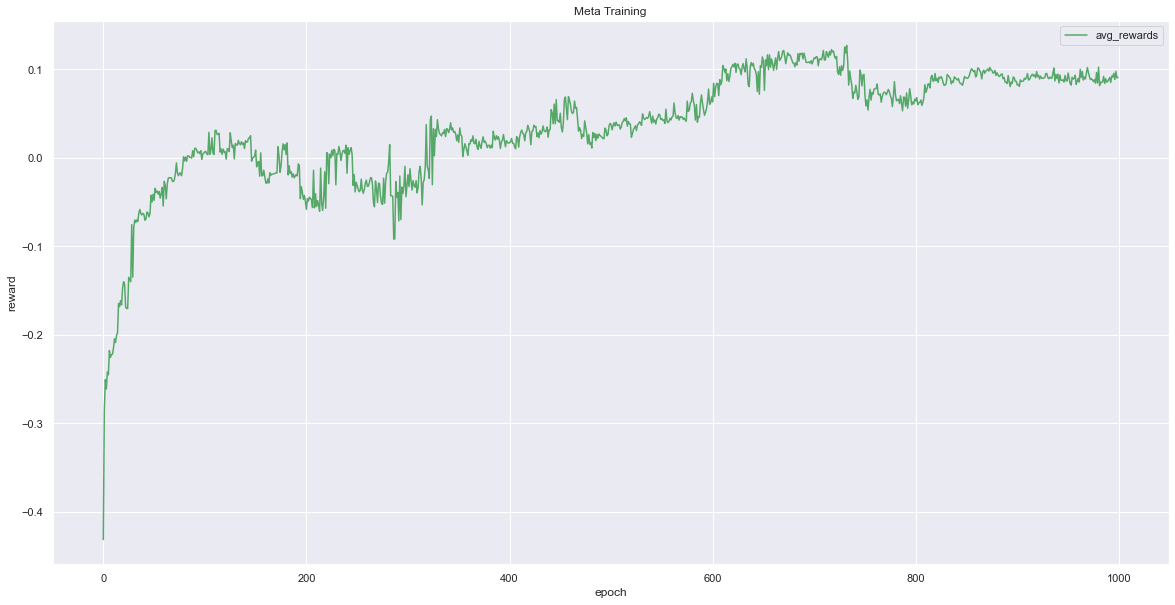

In [12]:
# Meta training plot
plt.figure(figsize = (20, 10))
plt.title("Meta Training")
plt.xlabel('epoch')
plt.ylabel('reward')
plt.plot(avg_rewards, label = 'avg_rewards', c = 'g')
plt.ticklabel_format(style='plain')
plt.legend()

saveFig(out_dir, 'meta')
plt.show()

In [13]:
days_total - days_train

18

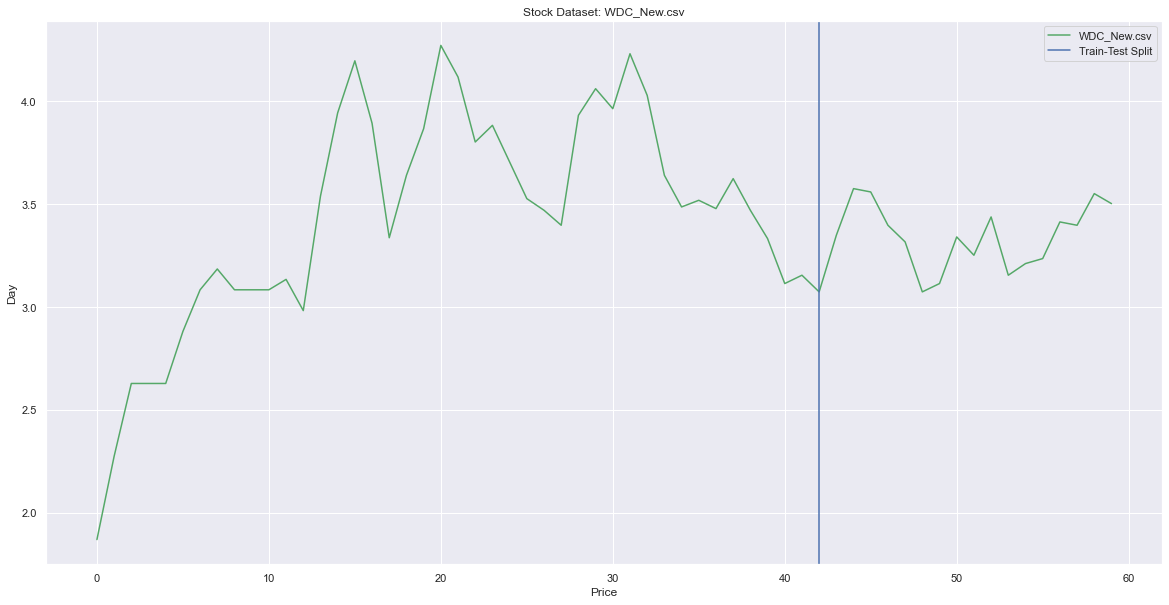

In [14]:
days_test = days_total - days_train

# Split test stage into train and test
test = datasets[-1]
test_dataset = datasets[-1][1]
t_train = test_dataset[:days_train] 
t_test = test_dataset[days_train:days_total]

c = test_dataset.Close.values.tolist()

# Test stock plot
plt.figure(figsize = (20, 10))
plt.title("Stock Dataset: " + test[0])
plt.xlabel('Price')
plt.ylabel('Day')
plt.plot(c, label = test[0], c = 'g')
plt.axvline(x=days_train, label = 'Train-Test Split')
plt.ticklabel_format(style='plain')
plt.legend()

saveFig(out_dir, 'test_stock')
plt.show()

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 1 units at price 3.550965, total balance 9997

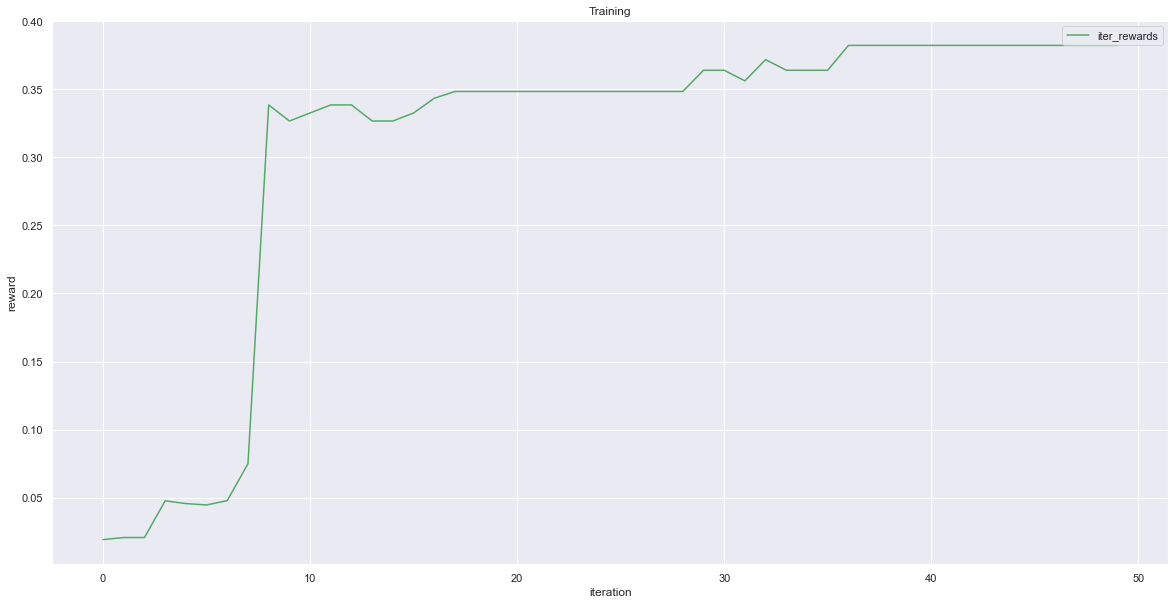

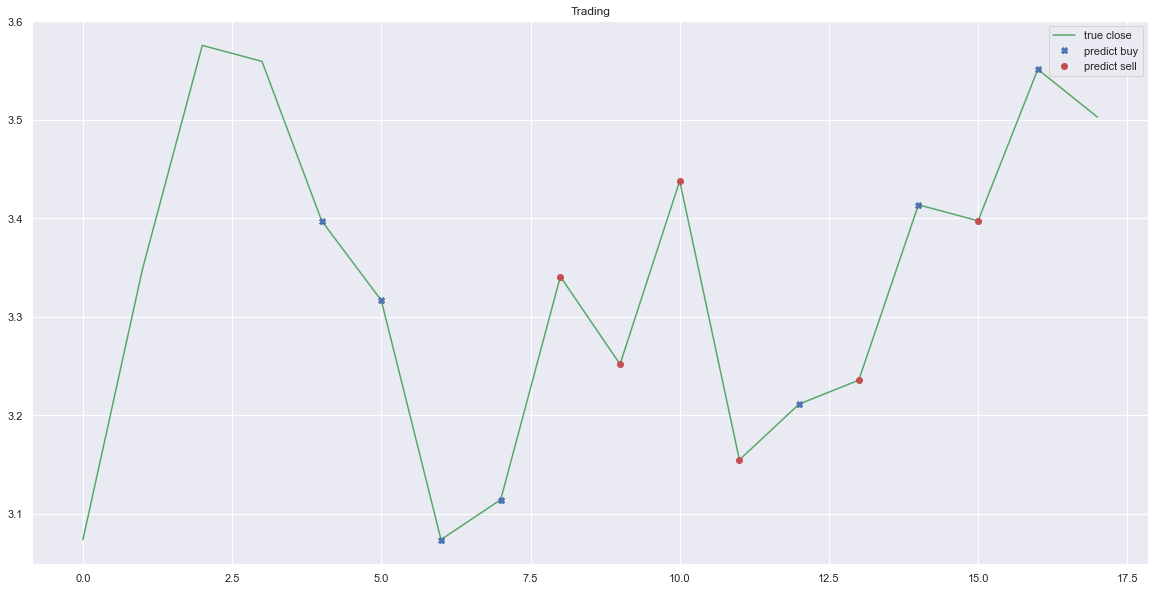

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 4 units at price 14.203860, total balance 998

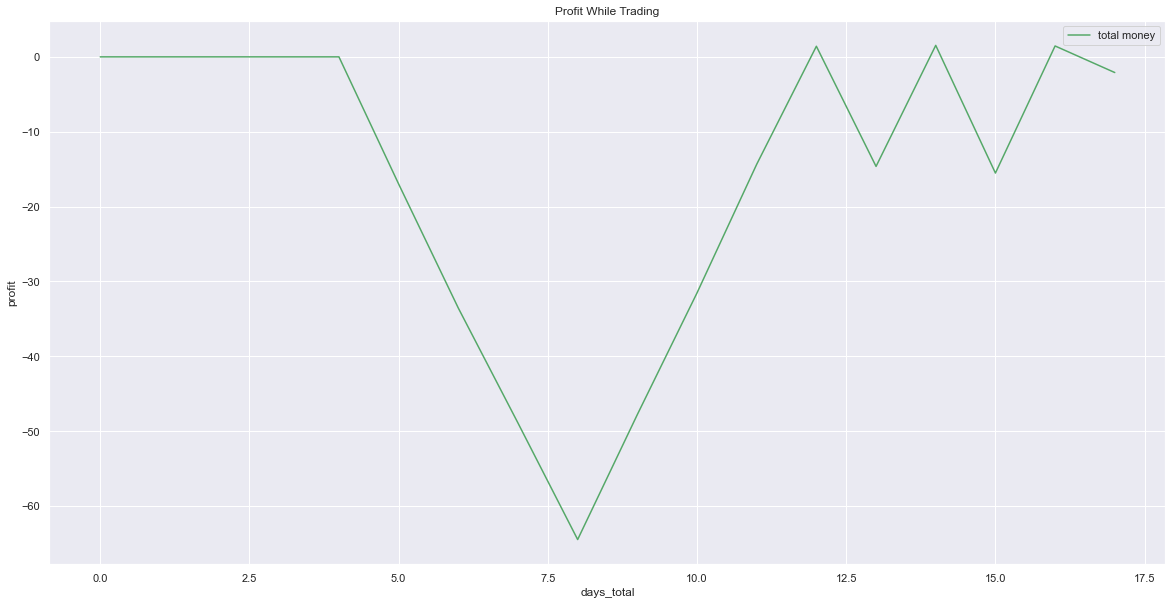

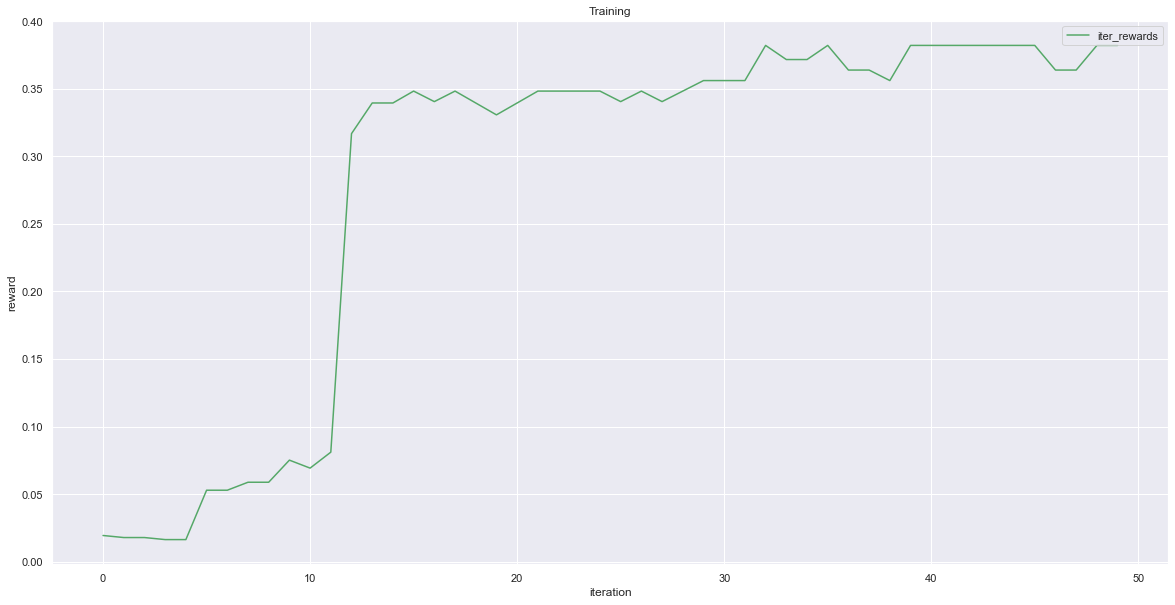

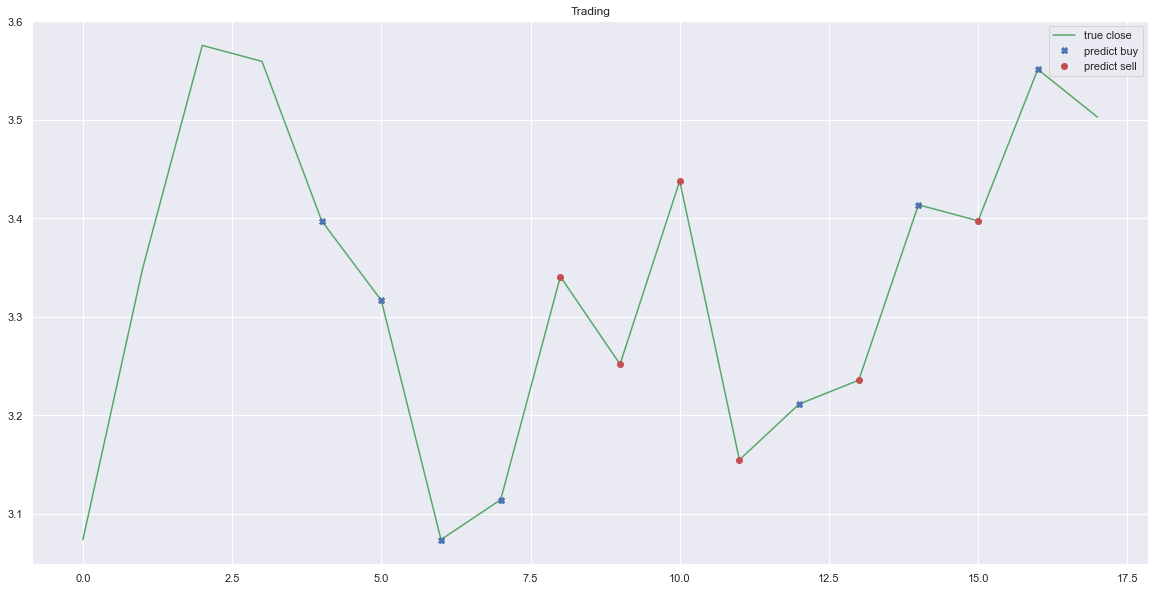

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 0 units at price 0.000000, total balance 1000

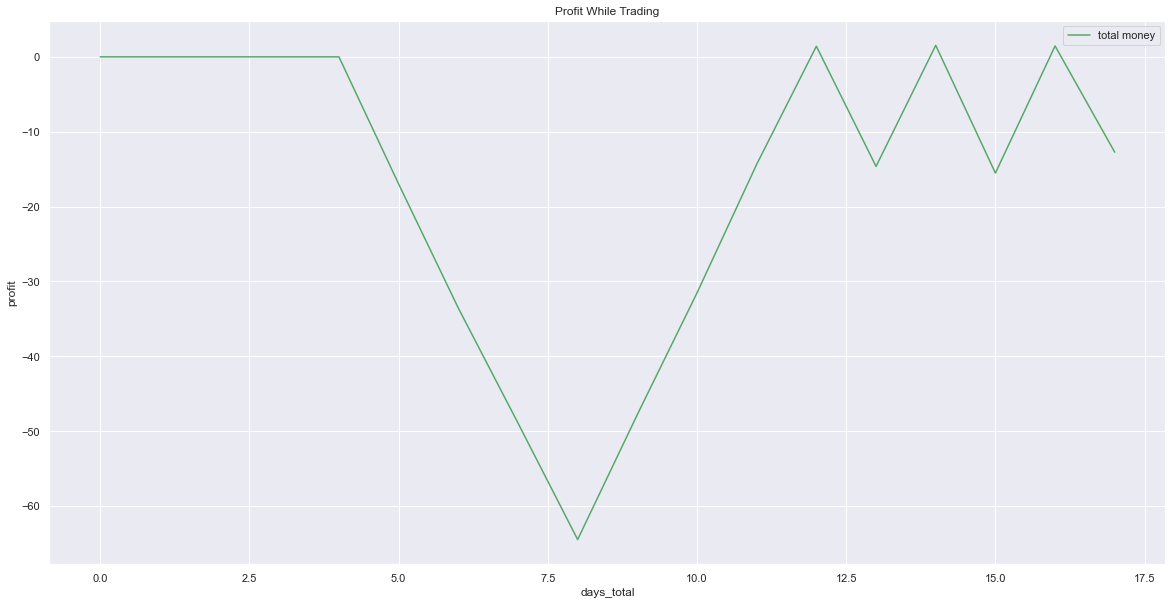

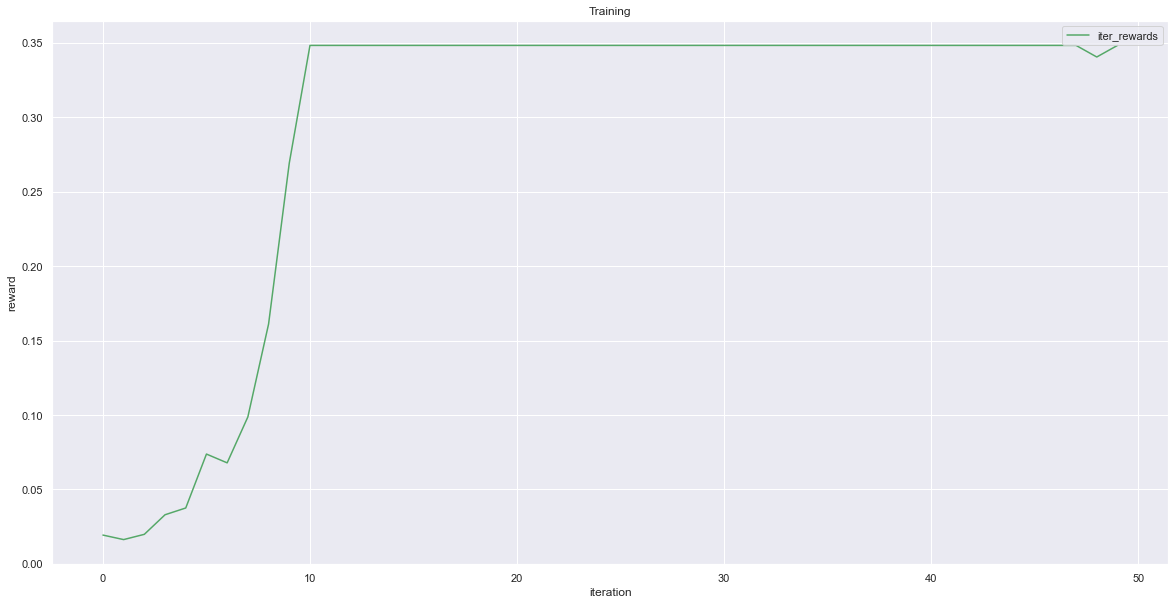

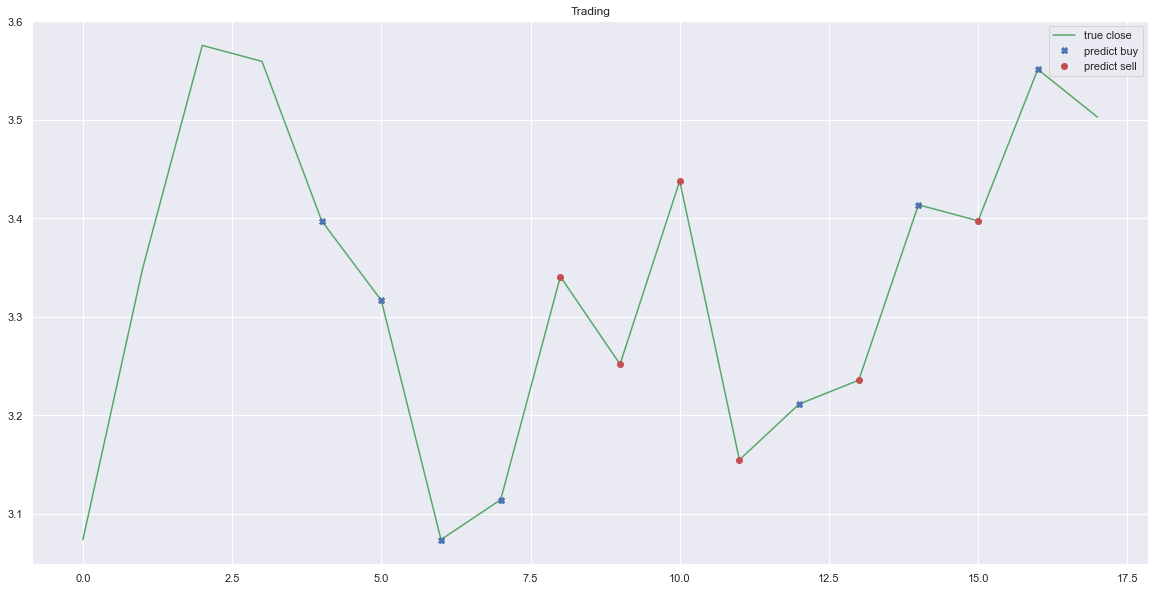

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 5 units at price 17.754825, total balance 998

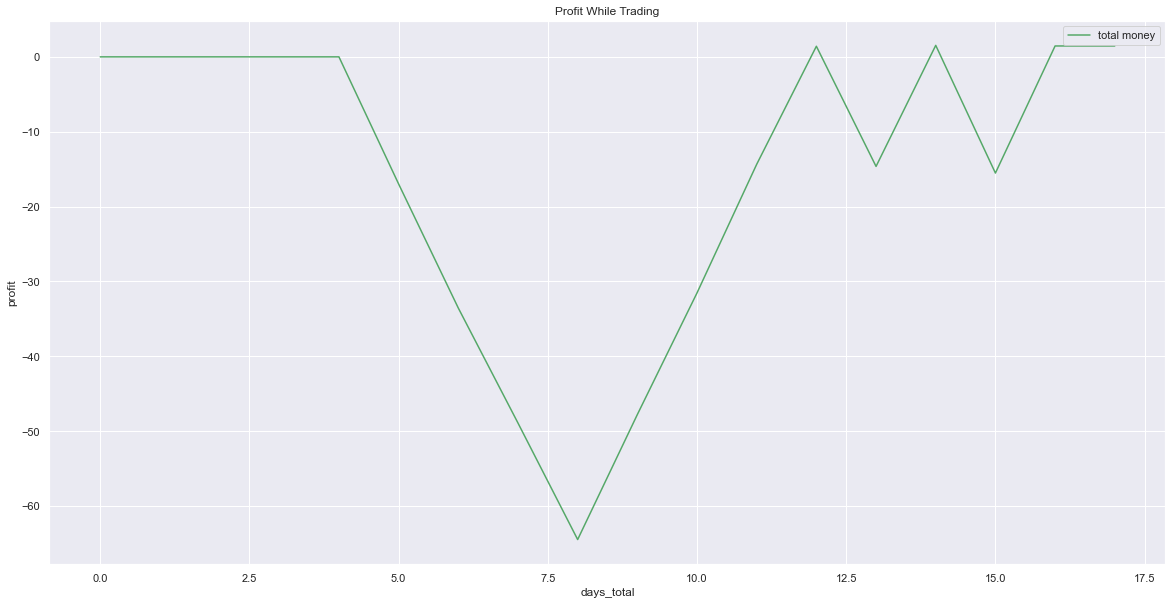

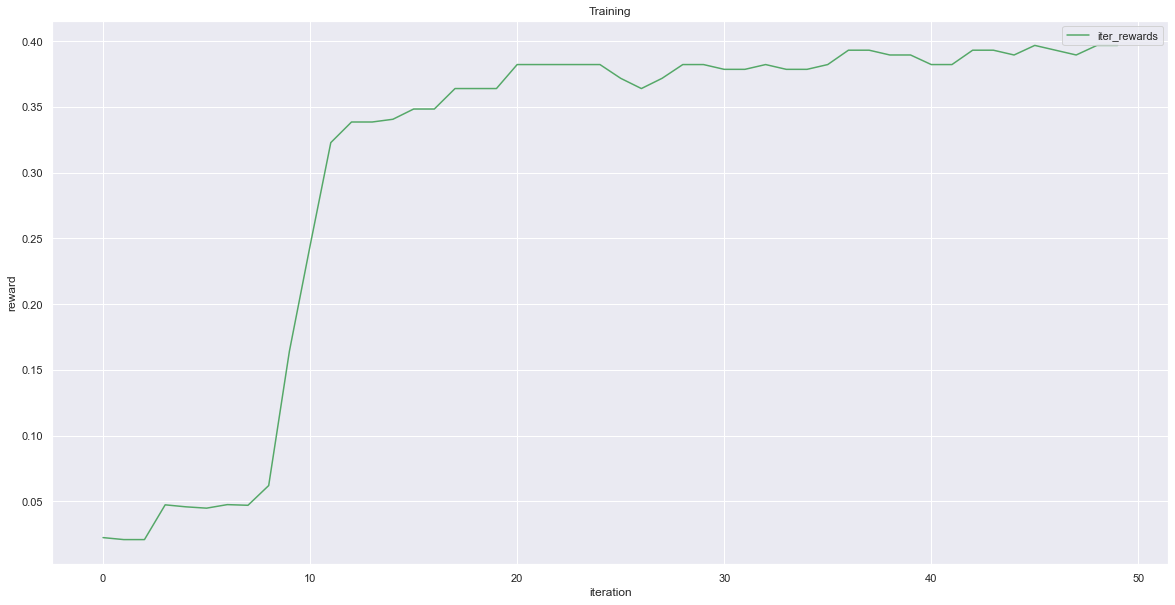

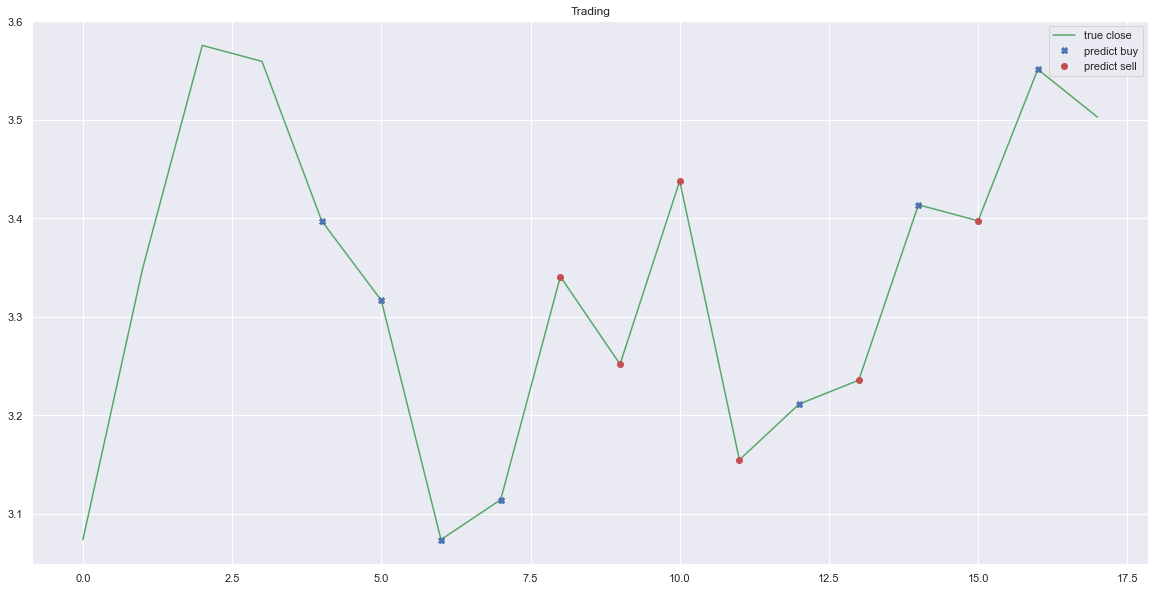

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 0 units at price 0.000000, total balance 1000

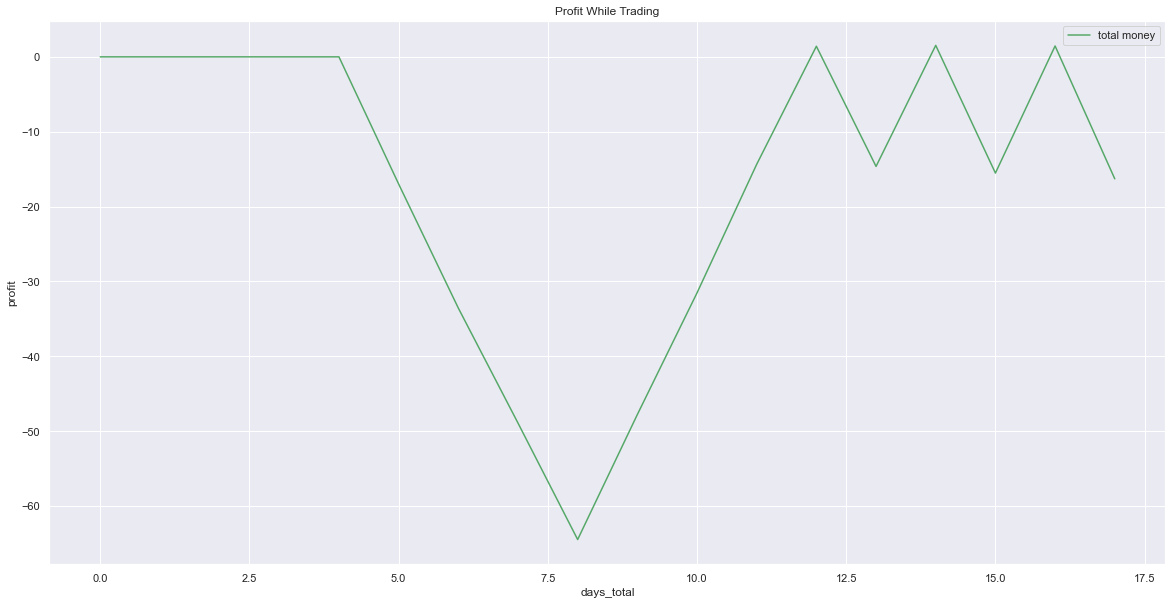

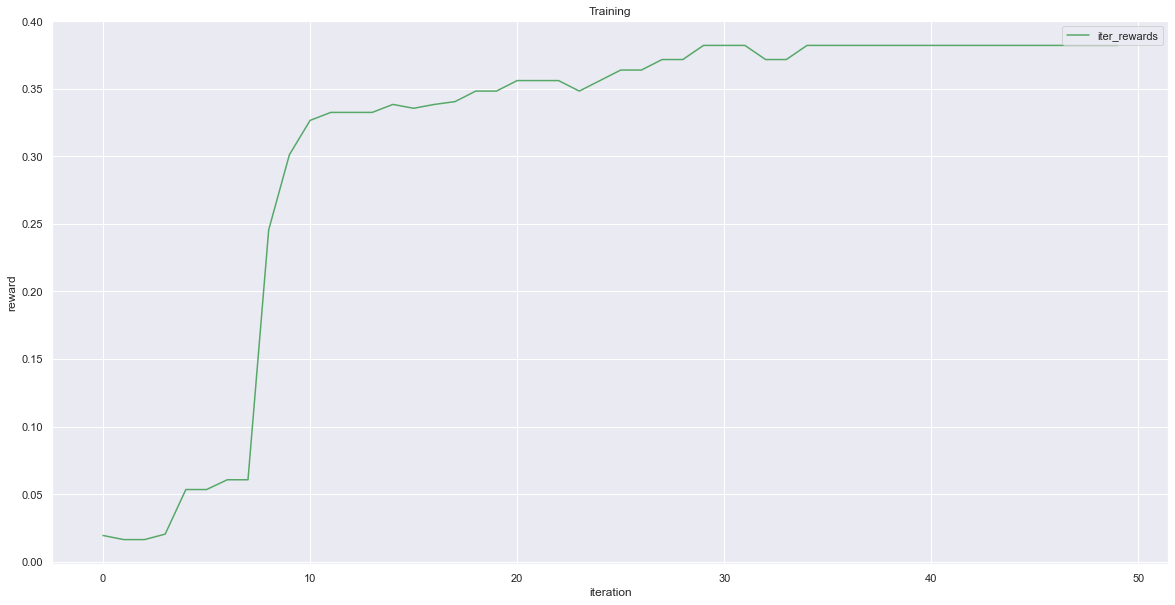

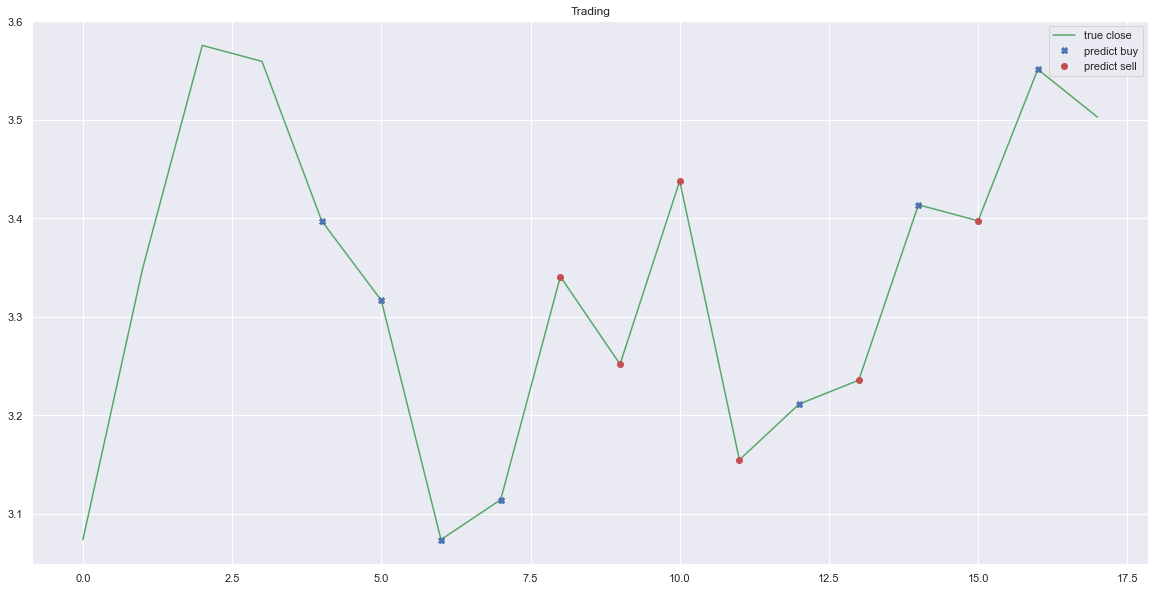

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 0 units at price 0.000000, total balance 1000

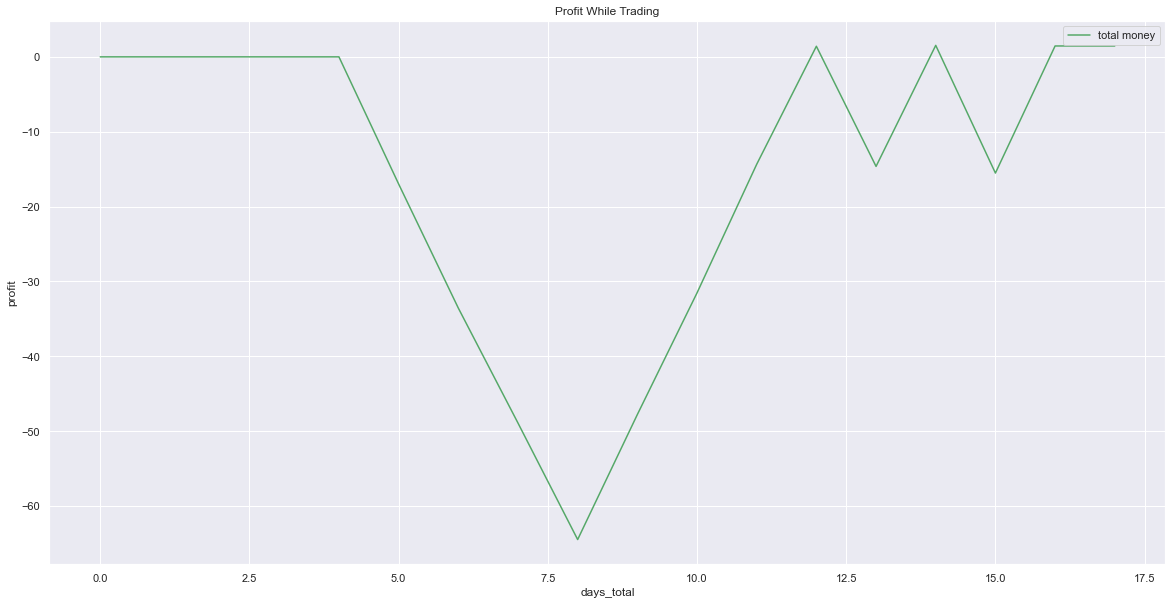

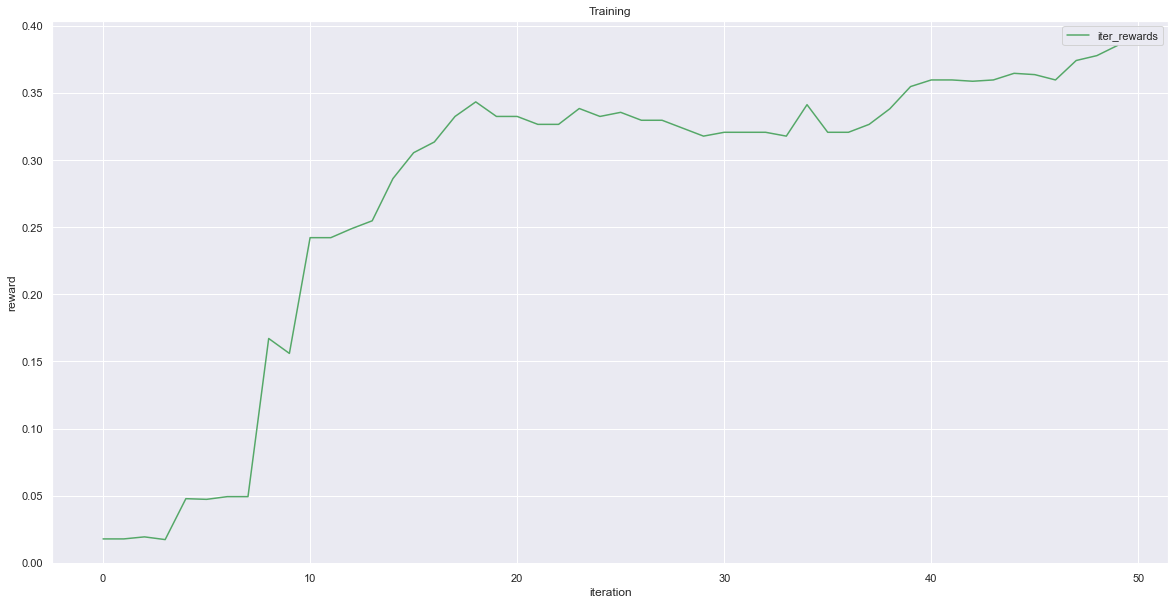

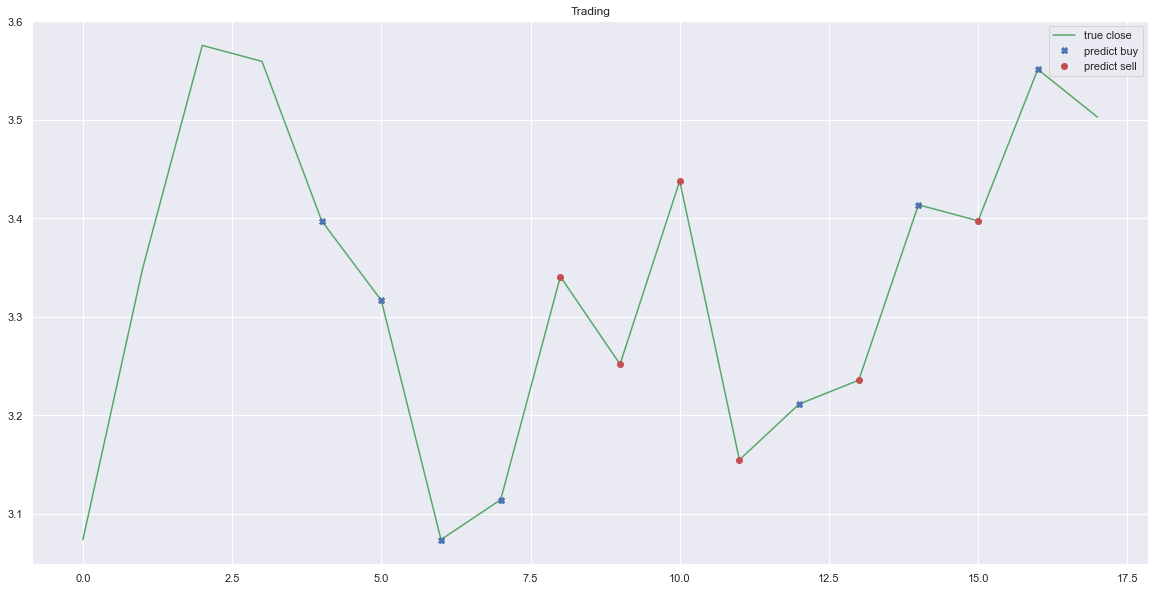

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 5 units at price 17.754825, total balance 998

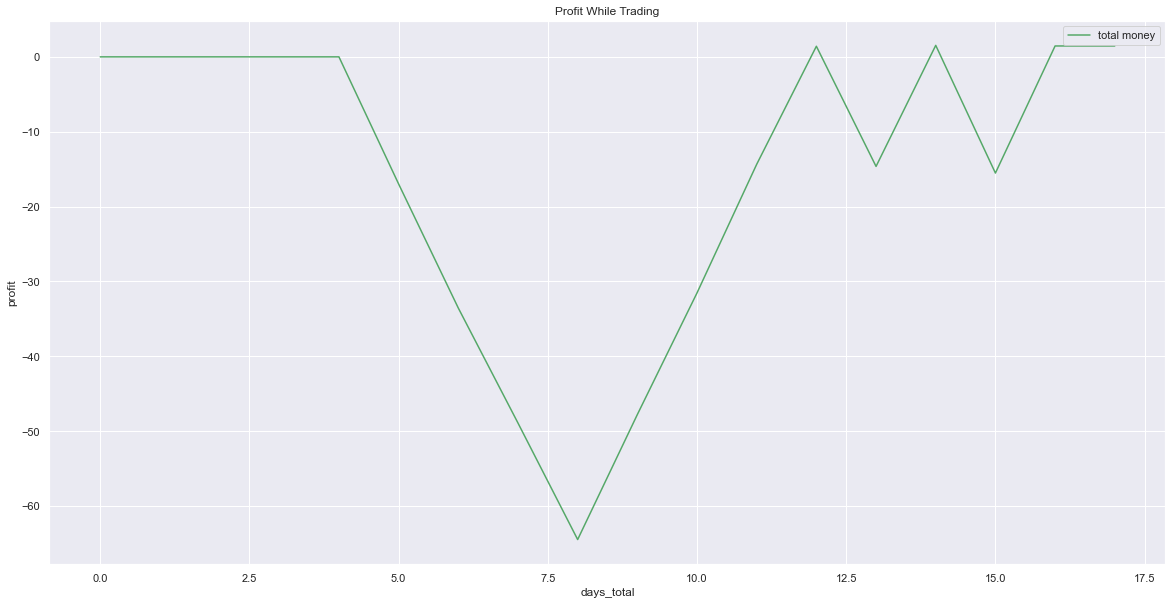

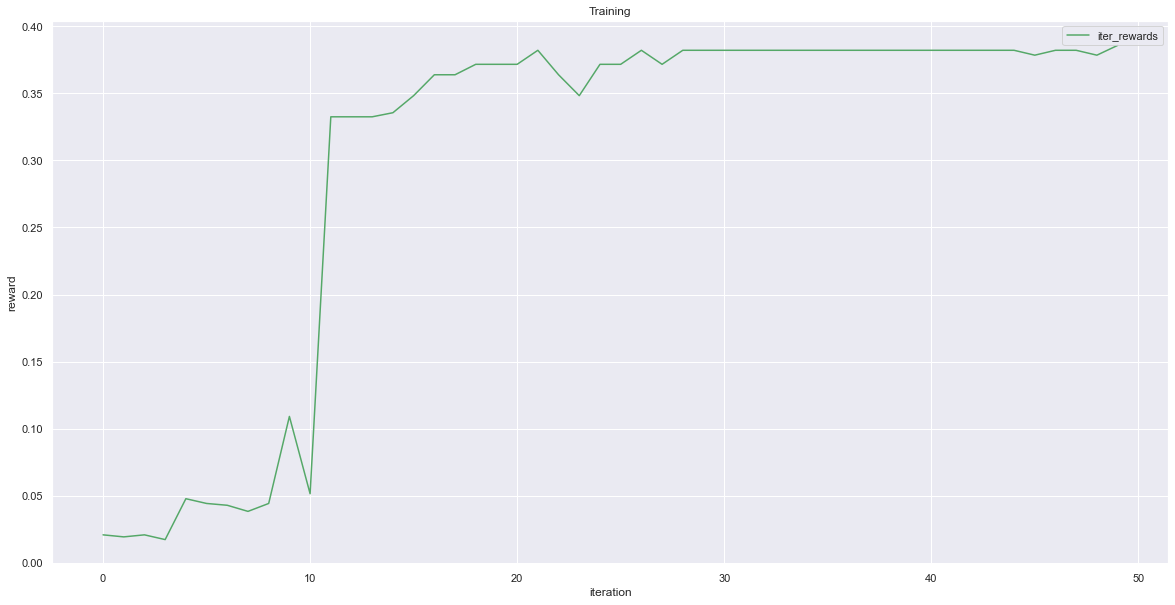

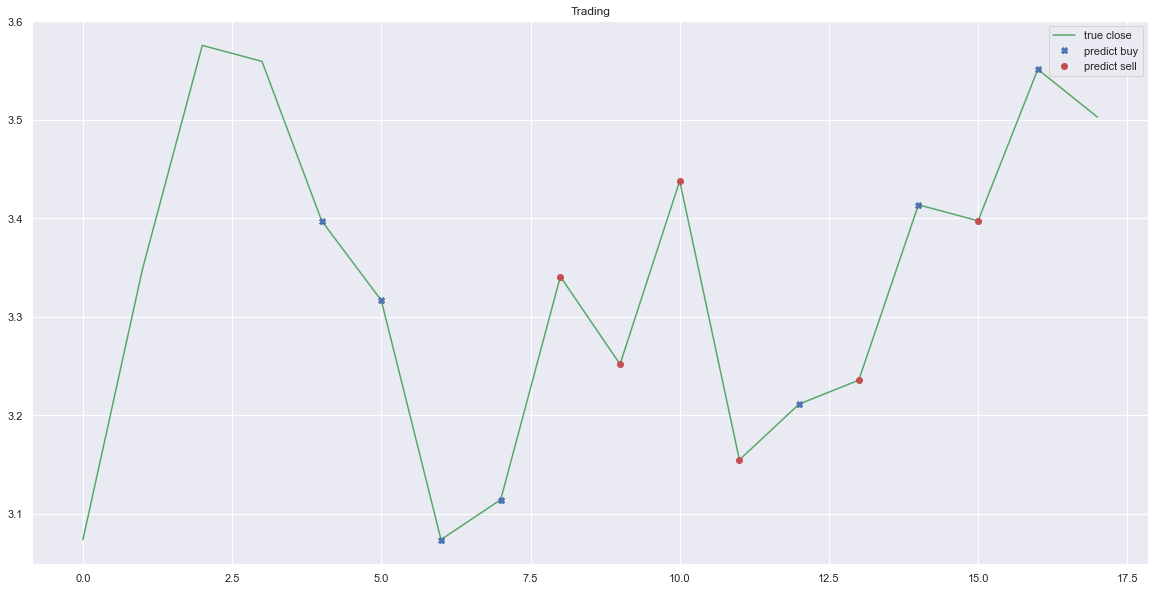

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 1 units at price 3.550965, total balance 9997

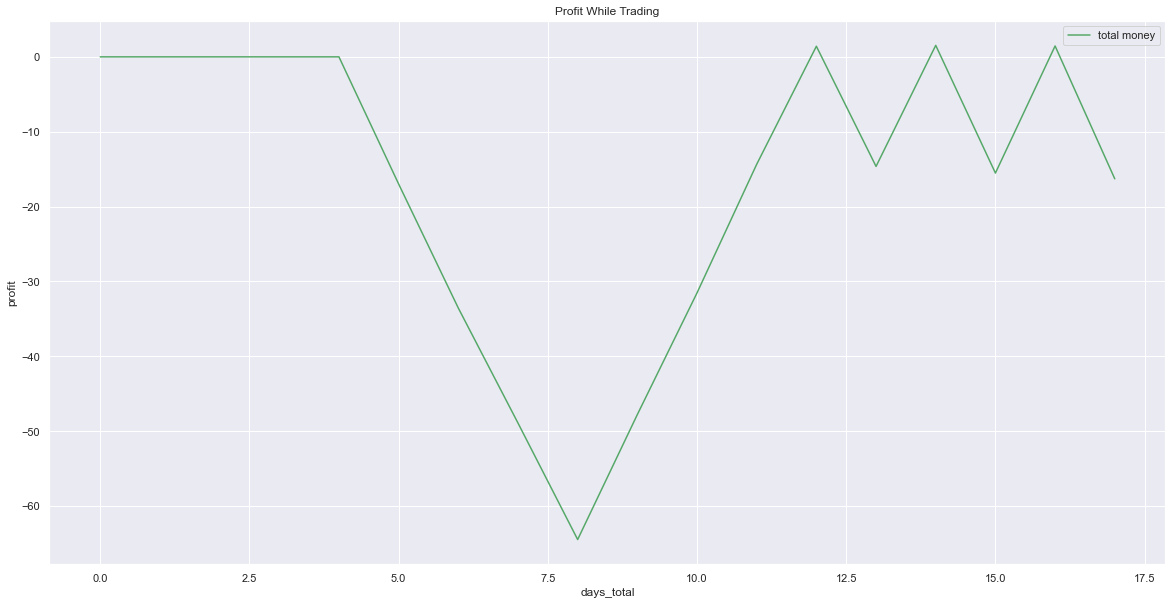

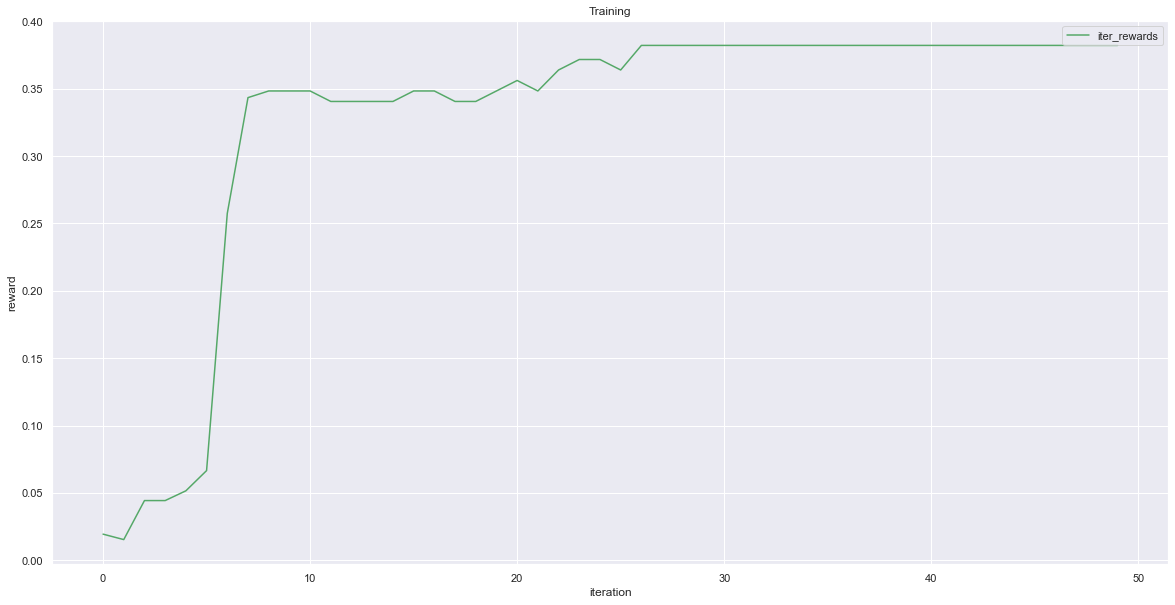

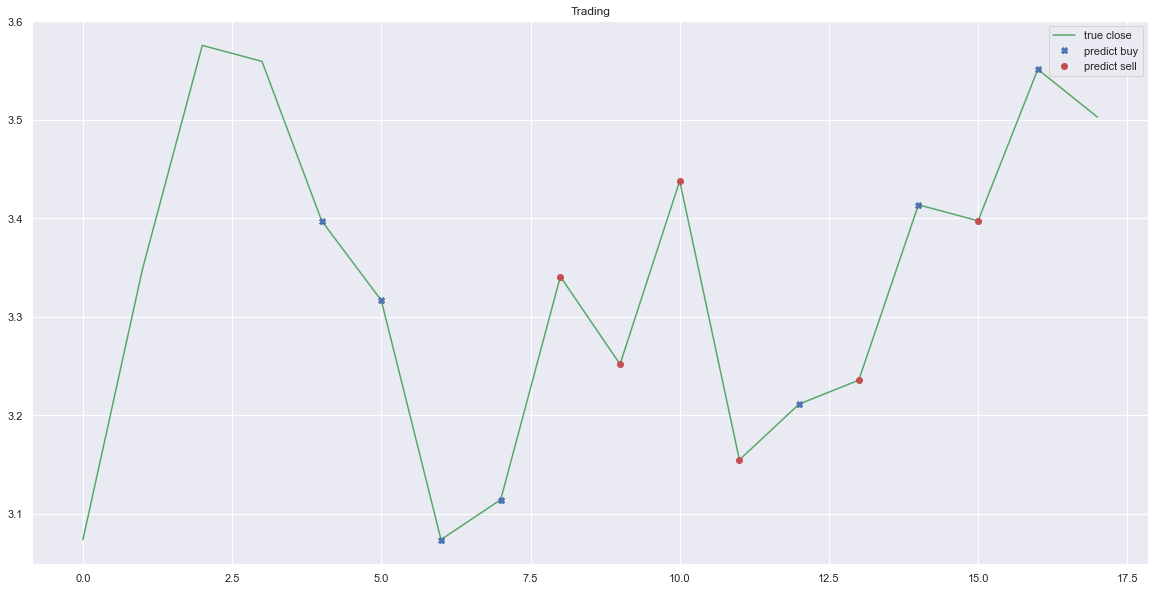

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 3 units at price 10.652895, total balance 999

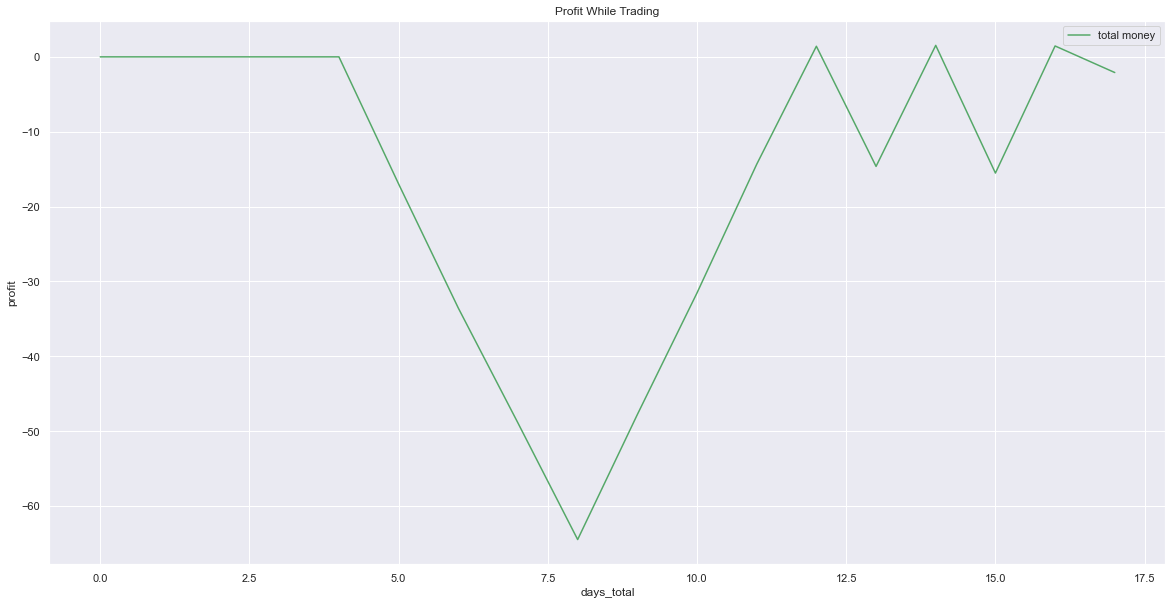

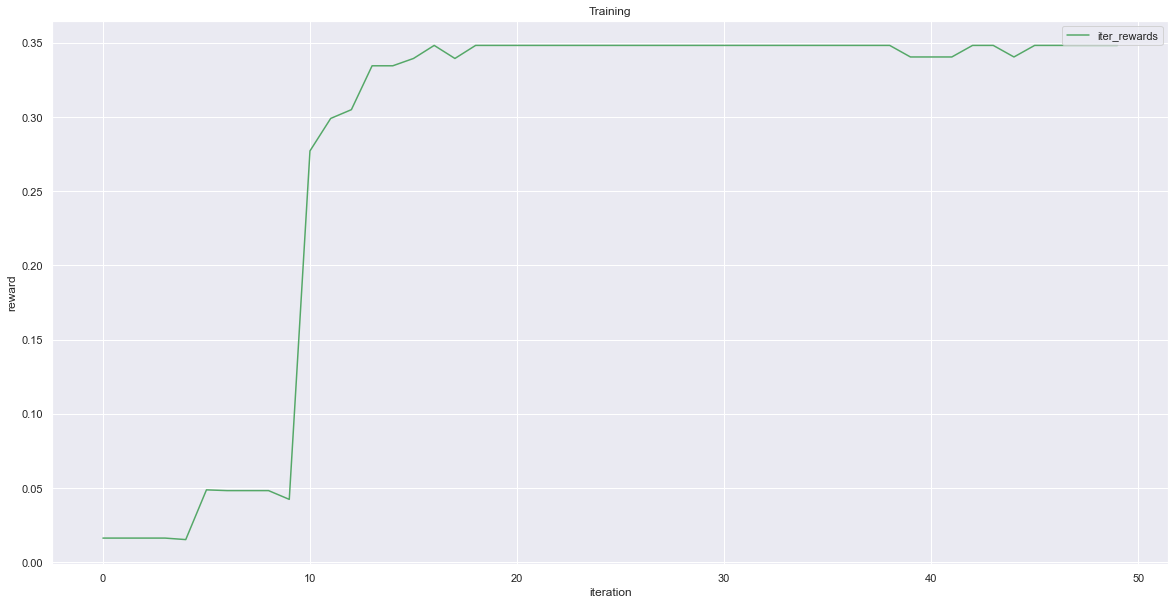

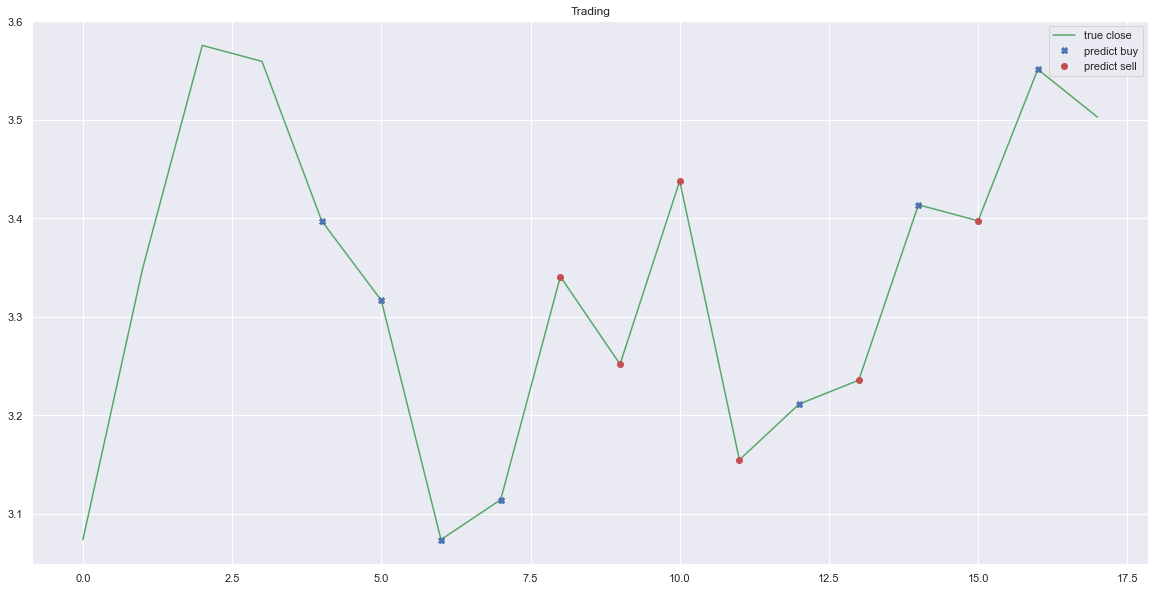

day 4: buy 5 units at price 16.986385, total balance 9983.013615
day 5: buy 5 units at price 16.581950, total balance 9966.431665
day 6: buy 5 units at price 15.368640, total balance 9951.063025
day 7: buy 5 units at price 15.570855, total balance 9935.492170
day 8, sell 5 units at price 16.703285, investment -1.666629 %, total balance 9952.195455,
day 9, sell 5 units at price 16.258400, investment -1.951218 %, total balance 9968.453855,
day 10, sell 5 units at price 17.188610, investment 11.842102 %, total balance 9985.642465,
day 11, sell 5 units at price 15.773075, investment 1.298708 %, total balance 10001.415540,
day 12: buy 5 units at price 16.056180, total balance 9985.359360
day 13, sell 5 units at price 16.177515, investment 0.755690 %, total balance 10001.536875,
day 14: buy 5 units at price 17.067275, total balance 9984.469600
day 15, sell 5 units at price 16.986385, investment -0.473948 %, total balance 10001.455985,
day 16: buy 2 units at price 7.101930, total balance 9994

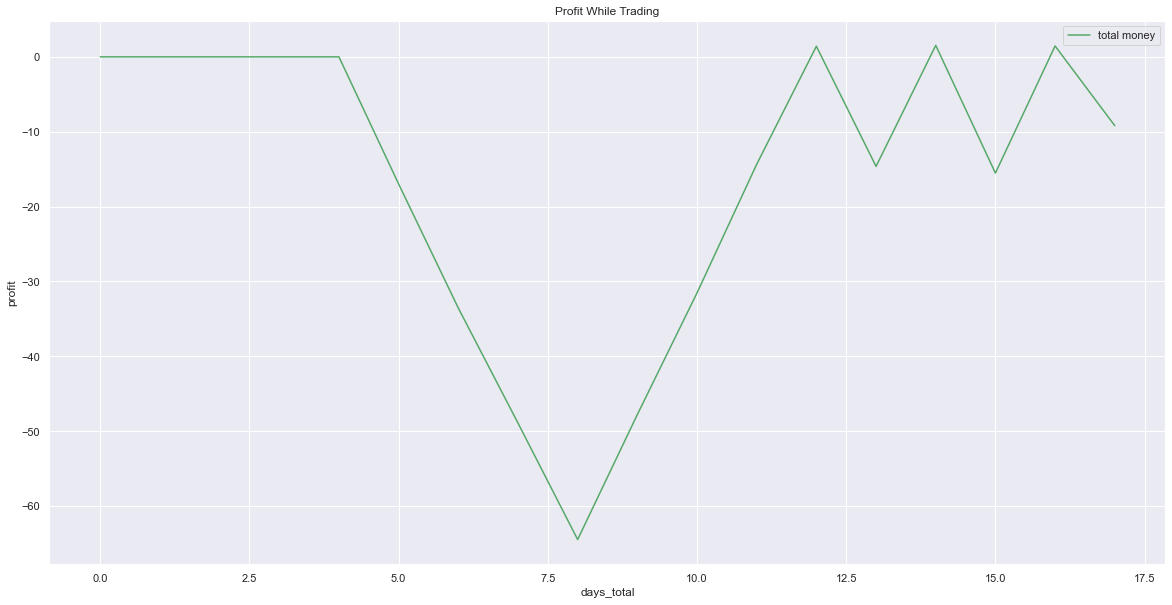

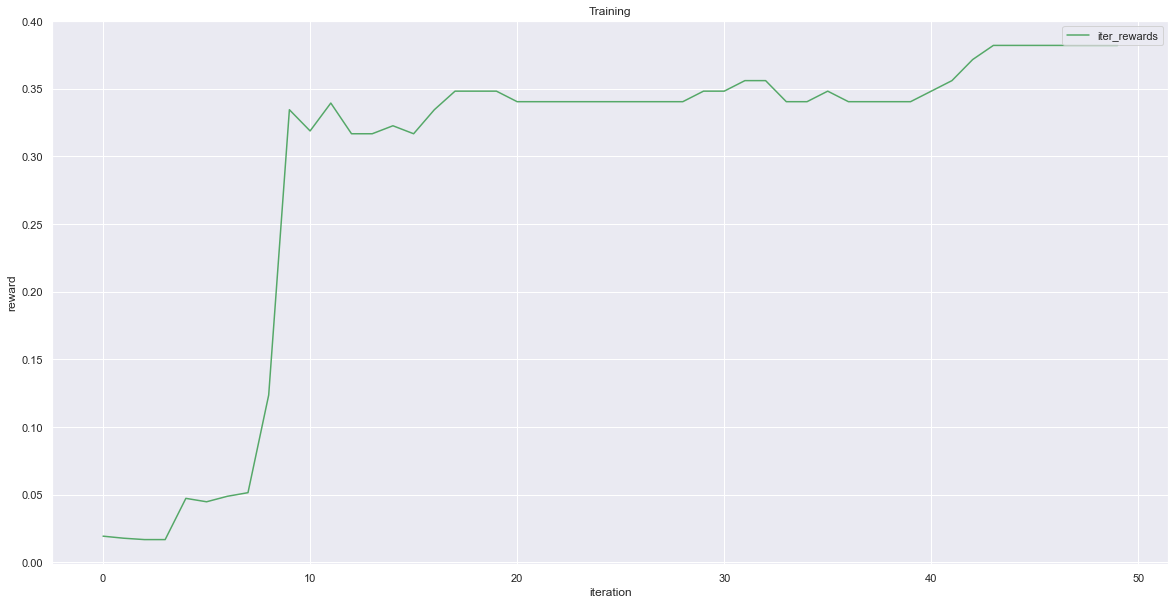

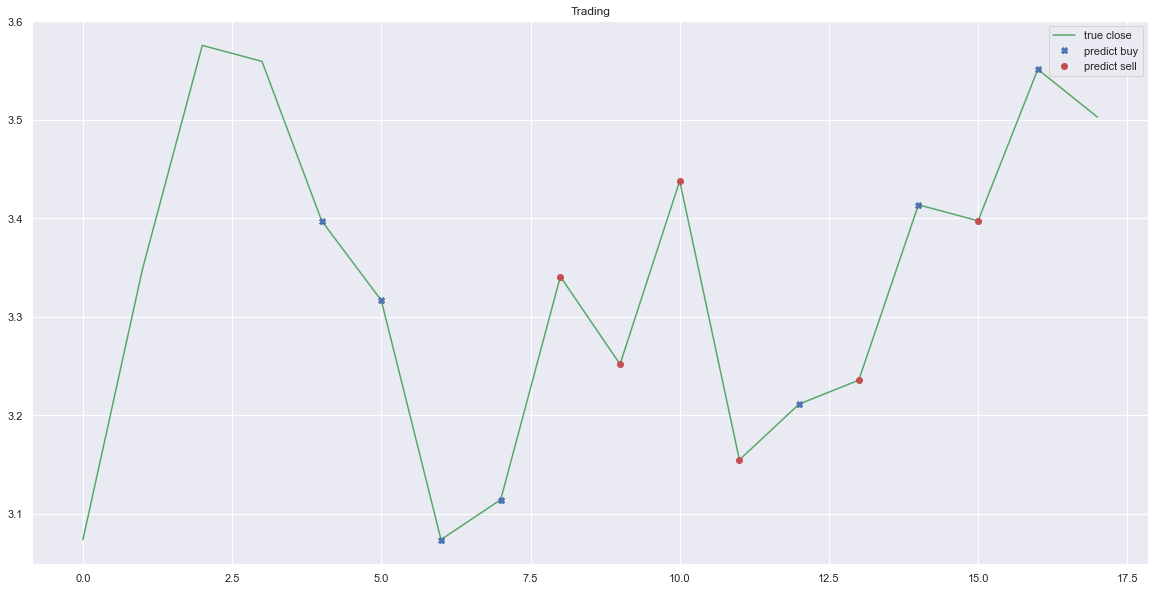

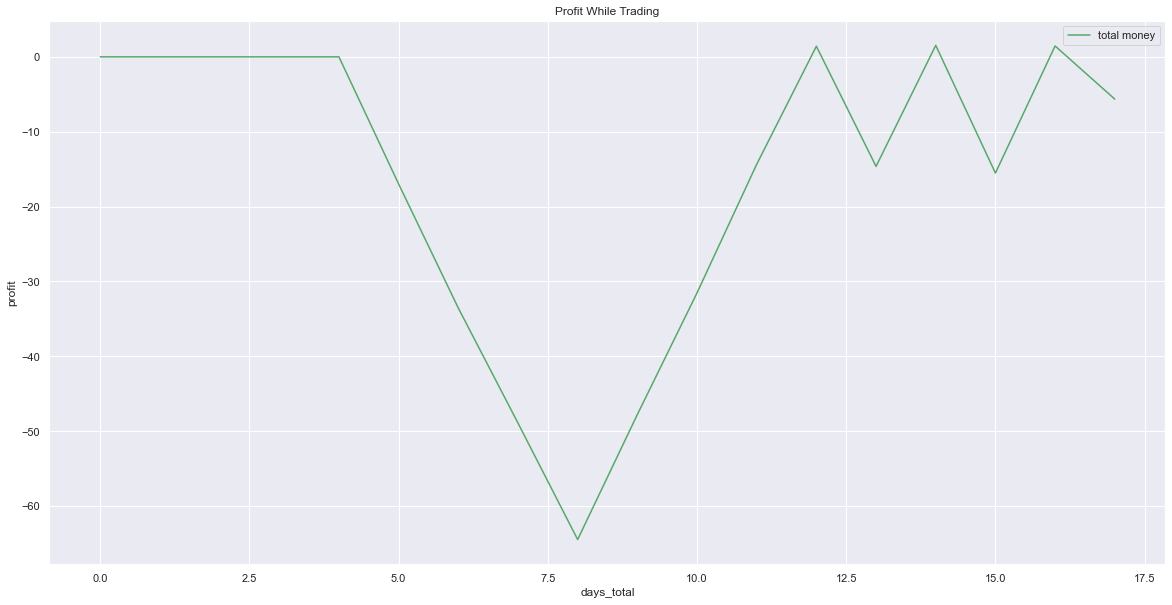

In [15]:
profits = []
labels = []

epoch_rewards = []
track_money = []

for i in range(0,sample_size):
    # Train
    close = t_train.Close.values.tolist()
    model.set_weights([feed_w1, decision_w2, buy_w3, feed_w4])
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    agent.fit(iterations = num_iter_test, checkpoint = 10)       
    
    # Train plots
    plt.figure(figsize = (20, 10))
    plt.title("Training")
    plt.xlabel('iteration')
    plt.ylabel('reward')
    plt.plot(epoch_rewards, label = 'iter_rewards', c = 'g')
    plt.ticklabel_format(style='plain')
    plt.legend()
    saveFig(out_dir, 'train')
#     plt.show()
    writeCSV(out_dir, "train_data", epoch_rewards)
    epoch_rewards = []
    
    #Test
    close = t_test.Close.values.tolist()
    agent = Agent(
        model = model,
        money = 10000,
        max_buy = 5,
        max_sell = 5,
        close = close,
        window_size = window_size,
        skip = 1,
    )
    
    # Test trade (plots trading in agent.but())
    agent.buy()
    profit = agent.get_profit()
    profits.append(profit)
    
    # Profit plots
    plt.figure(figsize = (20, 10))
    plt.ticklabel_format(style='plain')
    plt.title("Profit While Trading")
    plt.xlabel('days_total')
    plt.ylabel('profit')
    plt.plot(track_money, label = 'total money', c = 'g')
    plt.legend()
    saveFig(out_dir, 'trade_balance')
#     plt.show()
    writeCSV(out_dir, "profit_data", track_money)
    
    track_money = []
    labels.append(str(i))

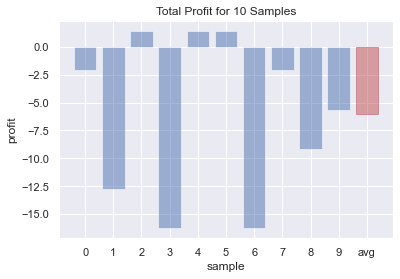

In [16]:
avg_profit = statistics.mean(profits) 
profits.append(avg_profit)
labels.append("avg")
y_pos = np.arange(len(profits))
plt.bar(y_pos, profits, align='center', alpha=0.5)[sample_size].set_color('r')
plt.xticks(y_pos, labels)
plt.ylabel('profit')
plt.xlabel('sample')
plt.title("Total Profit for " + str(len(profits) - 1) + " Samples")
saveFig(out_dir, 'results')
plt.show()
writeCSV(out_dir,"results_data",profits[:-1])